# LSTM

In [1]:
import os
# Filter out logs (additional) : 0 - all logs, 1 - INFO, 2 - WARNING, 3 - ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # or any {'0', '1', '2'}
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl
import subprocess
import tensorflow as tf
from tensorflow.keras.regularizers import L1L2


from src.data_preparation import load_data
from src.data_preparation.blocking_time_series_split import BlockingTimeSeriesSplit 
from src.data_preparation import mdl_dataset

from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class
from src.modelling import mdl_history

# from src.modelling import model_cnn
from src.modelling import model_lstm
from src.modelling import super_model_dl

from src.visualization import visualize_pca
from src.visualization import mdl_introspect
from src.visualization import mdl_ypred_PCA

from src.utils import reload_config
from src.utils import tardisml_utils

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# # add argument to pass config file
# import sys
# narg = len(sys.argv)  # number of arguments passed
# if narg > 1:
#     file_config = sys.argv[1]
# else:
    # file_config = '../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml'
    # file_config = '../config/config_to_jobs/config_LSTM_no_bias_debug.yaml'
file_config = '../config/config_default_2023_needs.yaml'
# file_config = '../config/for_paper/config_default_2023_var1.yaml'
# file_config = '../config/for_paper/config_default_2023_epoch_modified.yaml'
# file_config = '../config/for_paper/config_forcings_1.yaml'
# file_config = '../config/for_paper/config_default_2023_adjSIC_var4.yaml'


In [3]:
irootdir =  tardisml_utils.get_rootdir()

In [4]:
file_config

'../config/config_default_2023_needs.yaml'

In [5]:
rootdir = tardisml_utils.get_rootdir()
# file_config = '../config/data_proc_full.yaml'
conf = reload_config.Config(file_config, verbose=1)

Config file found: ../config/config_default_2023_needs.yaml


In [6]:
conf.rootdir = '/scratch/project_465000269/edelleo1/'

In [7]:
# ---------------------------------------------------
#               Activate gpu if possible
# ---------------------------------------------------
ngpu = len(tf.config.list_physical_devices('GPU'))
print("\nNum GPUs Available: ", ngpu)


# print(tf.__version__)
# print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(f'GPU device name:{tf.test.gpu_device_name()}')

# activation GPU
if ngpu > 0:
    tf.debugging.set_log_device_placement(True)  # debug: print placement (CPU or GPU) of operations
    print('Activation GPU')
    # print('CPU only')


Num GPUs Available:  0
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
GPU device name:


2024-01-31 14:10:50.155885: E tensorflow/compiler/xla/stream_executor/rocm/rocm_driver.cc:302] failed call to hipInit: HIP_ERROR_InvalidDevice


In [8]:
conf.forcing_fields

['2T_mean29d',
 'MSL_mean29d',
 '10V_mean29d',
 '10U_mean29d',
 'TP_mean29d',
 'SSR_mean29d',
 'STR_mean29d']

In [9]:
filename = '/scratch/project_465000269/edelleo1/Leo/results/pca_i100-550_j150-629/PC_2T_4N_29d_2011_2022.pkl'

In [ ]:
sda

In [13]:
from src.data_preparation import mdl_dataset_format

In [10]:
from importlib import reload

In [13]:
reload(mdl_dataset)

<module 'src.data_preparation.mdl_dataset' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/mdl_dataset.py'>

In [25]:
reload(mdl_dataset_format)

<module 'src.data_preparation.mdl_dataset_format' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/mdl_dataset_format.py'>

In [14]:
# ---------------------------------------------------
#                 Loading data
# ---------------------------------------------------

#ds = mdl_dataset.Dataset(conf, setup='no_bias', history=new_hist, var_to_keep=var_to_keep)
# ds = mdl_dataset.Dataset(conf, setup=conf.setup, history=new_hist, var_to_keep=var_to_keep, non_assimilated=conf.non_ass)  #'adjSIC')

ds = mdl_dataset.Dataset(conf, setup=conf.setup, non_assimilated=conf.non_ass)


Initialisation dataset...
History loaded from config file: ../config/config_default_2023_needs.yaml
Loading data...
	Loading sia...
	Retrieve siconc
	Retrieve sisnthick
	Retrieve zos
	Retrieve vxsi
	Retrieve vysi
Scaling...
	Scalers saved as /scratch/project_465000269/edelleo1/Leo/results/lstm_240115-174953/ml/scalers.pkl
Size of the training set:    2612 days
Size of the validation set:   653 days
Size of the test set:        1096 days
Config file updated 'ntrain': ../config/config_default_2023_needs.yaml
Config file updated 'nval': ../config/config_default_2023_needs.yaml
Config file updated 'ntest': ../config/config_default_2023_needs.yaml
Dataset Format for lstm
Config file updated 'needfutur': ../config/config_default_2023_needs.yaml
Config file updated 'needpast': ../config/config_default_2023_needs.yaml
Dataset formatted from (4361, 224) to (4340, 4, 224) for H=[0, 7, 14, 21].
Config file updated 'ntest': ../config/config_default_2023_needs.yaml


In [14]:
from importlib import reload

In [35]:
from src.data_preparation import mdl_dataset_format

In [68]:
reload(mdl_dataset)

<module 'src.data_preparation.mdl_dataset' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/mdl_dataset.py'>

In [69]:
reload(mdl_dataset_prep)

<module 'src.data_preparation.mdl_dataset_prep' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/mdl_dataset_prep.py'>

In [70]:
reload(mdl_dataset_format)

<module 'src.data_preparation.mdl_dataset_format' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/mdl_dataset_format.py'>

In [71]:
# ---------------------------------------------------
#                 Loading data
# ---------------------------------------------------

#ds = mdl_dataset.Dataset(conf, setup='no_bias', history=new_hist, var_to_keep=var_to_keep)
# ds = mdl_dataset.Dataset(conf, setup=conf.setup, history=new_hist, var_to_keep=var_to_keep, non_assimilated=conf.non_ass)  #'adjSIC')

ds = mdl_dataset.Dataset(conf, setup=conf.setup, non_assimilated=conf.non_ass, do_scaling=True, objective='apply91')


Initialisation dataset...
History loaded from config file: ../config/for_paper/config_default_2023_var1.yaml
Loading data...

> Bias not loaded because dataset is used for application.

	Loading sia...
	Retrieve siconc
	Retrieve sisnthick
	Retrieve zos
	Retrieve vxsi
	Retrieve vysi
Scaling...
	Scalers loaded from /scratch/project_465000269/edelleo1/Leo/results/lstm_231211-153502/ml/scalers.pkl
Dataset Format for lstm
Dataset formatted from (2717, 192) to (2696, 4, 192) for H=[0, 7, 14, 21].
Config file updated 'ntest': ../config/for_paper/config_default_2023_var1.yaml


In [72]:
ds.dataset['X'].ndim

3

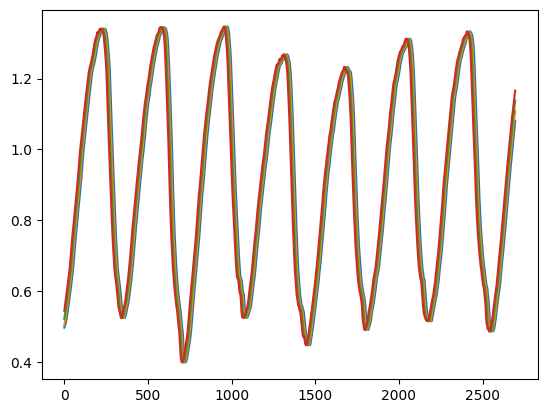

In [73]:
plt.plot(ds.dataset['X'][:,:,0])

# FIXING SCALING

In [7]:
from sklearn.preprocessing import MinMaxScaler

import copy
import pickle

In [8]:
X = copy.deepcopy(ds.dataset['X'])
scalers = {}

# define scalers
for n in range(X.shape[-1]):
    scalers[n] = MinMaxScaler()
    X[:,:,n] = scalers[n].fit_transform(X[:,:,n])    

# save
with open('scalers.pkl', 'wb') as handle:
    pickle.dump(scalers, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Load scalers from training dataset
with open('scalers.pkl', 'rb') as handle:
    b = pickle.load(handle)

pkl_X = np.empty((4340,4,224))  # << change dimensions

# Transform new values with scalers
for n in range(pkl_X.shape[-1]):
    pkl_X[:,:,n] = b[n].transform(ds.dataset['X'][:,:,n])

In [21]:
ds.config.rootdir

'/scratch/project_465000269/edelleo1/'

In [23]:
ds.config.ml_dir

'Leo/results/lstm_231122-160007/ml/'

In [18]:
np.empty(X.shape).shape

(4340, 4, 224)

In [11]:
(X==pkl_X).all()

True

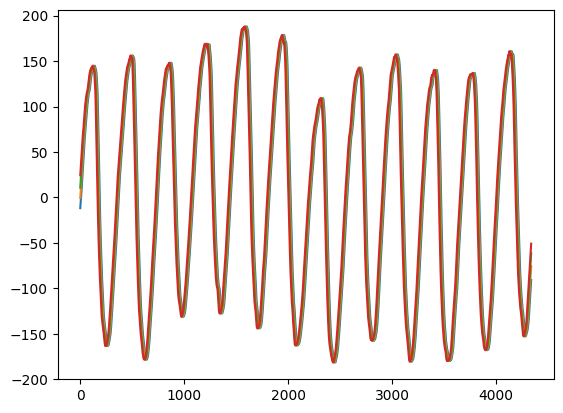

In [6]:
plt.plot(ds.dataset['X'][:,:,0])

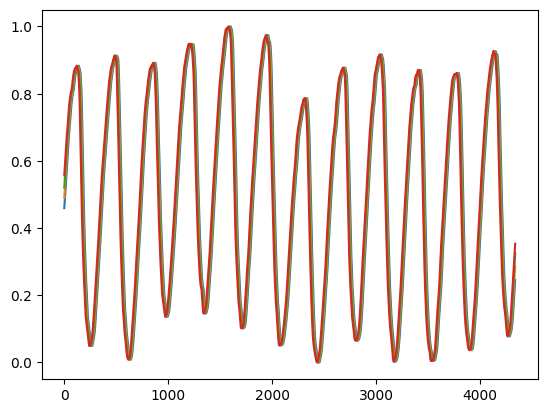

In [12]:
plt.plot(X[:,:,0])

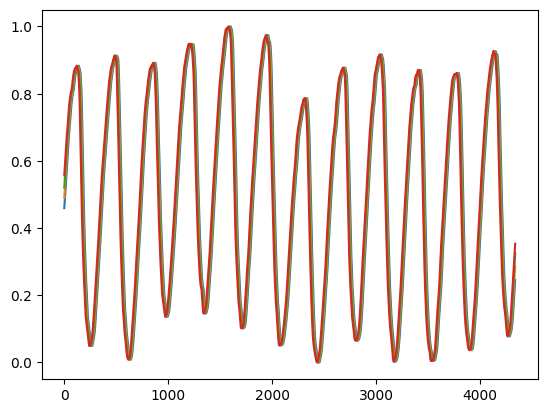

In [13]:
plt.plot(pkl_X[:,:,0])